
# Decision Tree Analysis for Employee Attrition Prediction

## Setup and Data Loading

In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydot

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import export_graphviz, DecisionTreeClassifier

from six import StringIO
from IPython.display import display, Image, HTML

sns.set_style("whitegrid")

In [160]:
df = pd.read_csv("../data/ibm-employee-data.csv")
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## Exploratory Data Analysis

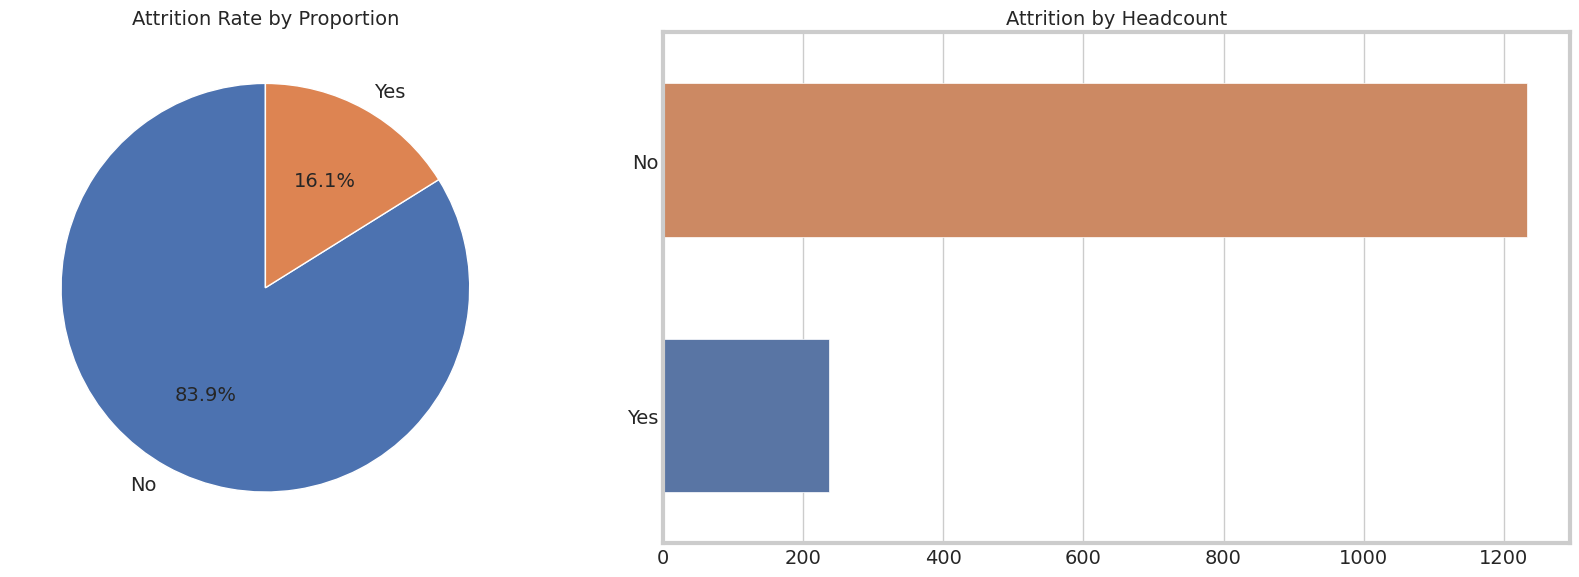

In [161]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Pie Chart
df['Attrition'].value_counts().plot.pie(
    ax=axes[0],
    autopct='%1.1f%%',
    colors=sns.color_palette('deep'),
    startangle=90,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)
axes[0].set_title('Attrition Rate by Proportion', fontsize=14)
axes[0].set_ylabel('')

# Horizontal Bar Chart
sns.countplot(
    y='Attrition',
    data=df,
    ax=axes[1],
    hue='Attrition',
    palette='deep',
    order=df['Attrition'].value_counts().index,
    width=0.6
)
axes[1].set_title('Attrition by Headcount', fontsize=14)
axes[1].set_xlabel('')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [162]:
df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis="columns", inplace=True)

categorical_col = []
for column in df.columns:
    if df[column].dtype == object and len(df[column].unique()) <= 50:
        categorical_col.append(column)

df['Attrition'] = df.Attrition.astype("category").cat.codes

def display_counts(df, columns):
    for col in columns:
        html = df[col].value_counts().to_frame().reset_index()
        html.columns = [col, 'Count']
        display(HTML(f"<h4>{col}</h4>"))
        display(html)

display_counts(df, categorical_col)

,Attrition,Count
0,0,1233
1,1,237


,BusinessTravel,Count
0,Travel_Rarely,1043
1,Travel_Frequently,277
2,Non-Travel,150


,Department,Count
0,Research & Development,961
1,Sales,446
2,Human Resources,63


,EducationField,Count
0,Life Sciences,606
1,Medical,464
2,Marketing,159
3,Technical Degree,132
4,Other,82
5,Human Resources,27


,Gender,Count
0,Male,882
1,Female,588


,JobRole,Count
0,Sales Executive,326
1,Research Scientist,292
2,Laboratory Technician,259
3,Manufacturing Director,145
4,Healthcare Representative,131
5,Manager,102
6,Sales Representative,83
7,Research Director,80
8,Human Resources,52


,MaritalStatus,Count
0,Married,673
1,Single,470
2,Divorced,327


,OverTime,Count
0,No,1054
1,Yes,416


## Data Processing

In [163]:
categorical_col.remove('Attrition')
print("Categorical columns after removing 'Attrition':")
for col in categorical_col:
    print(f"- {col}")

Categorical columns after removing 'Attrition':
- BusinessTravel
- Department
- EducationField
- Gender
- JobRole
- MaritalStatus
- OverTime


In [164]:
label = LabelEncoder()
for column in categorical_col:
    df[column] = label.fit_transform(df[column])

print("DataFrame info after Label Encoding:")
df[categorical_col].head()

DataFrame info after Label Encoding:


,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime
0,2,2,1,0,7,2,1
1,1,1,1,1,6,1,0
2,2,1,4,1,2,2,1
3,1,1,1,0,6,1,1
4,2,1,3,1,2,1,0


In [165]:
X = df.drop('Attrition', axis=1)
y = df.Attrition

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("X DataFrame head:")
X.head()

X DataFrame head:


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,2,1102,2,1,2,1,2,0,94,...,3,1,0,8,0,1,6,4,0,5
1,49,1,279,1,8,1,1,3,1,61,...,4,4,1,10,3,3,10,7,1,7
2,37,2,1373,1,2,2,4,4,1,92,...,3,2,0,7,3,3,0,0,0,0
3,33,1,1392,1,3,4,1,4,0,56,...,3,3,0,8,3,3,8,7,3,0
4,27,2,591,1,2,1,3,1,1,40,...,3,4,1,6,3,3,2,2,2,2


In [166]:
print("y Series head:")
y.head()

y Series head:


0    1
1    0
2    1
3    0
4    0
Name: Attrition, dtype: int8

## Applying Tree Algorithms

In [167]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        data, label = X_train, y_train
        phase = "Train"
    else:
        data, label = X_test, y_test
        phase = "Test"

    pred = clf.predict(data)
    acc = accuracy_score(label, pred) * 100

    # Map numeric labels to strings
    label_map = {0: 'No', 1: 'Yes'}
    true_labels = pd.Series(label).map(label_map)
    pred_labels = pd.Series(pred).map(label_map)

    # Generate report and confusion matrix
    clf_report = pd.DataFrame(classification_report(true_labels, pred_labels, output_dict=True)).T
    cm = confusion_matrix(true_labels, pred_labels, labels=['No', 'Yes'])
    labels_str = ['No', 'Yes']

    # Print Accuracy
    print(f"\n{phase} Result:\n{'—'*40}")
    print(f"Accuracy: {acc:.2f}%")
    display(clf_report.round(2))
    print("")

    # Plot Confusion Matrix
    fig, ax = plt.subplots(1, 2, figsize=(18, 7))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0],
                xticklabels=labels_str, yticklabels=labels_str)
    ax[0].set_title(f'{phase} Confusion Matrix', fontsize=16)
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')

    # Plot Class-wise F1 Scores
    clf_report_no_avg = clf_report.drop(index=['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
    clf_report_no_avg['f1-score'].plot(kind='barh', ax=ax[1], color='mediumseagreen')
    ax[1].set_title(f'{phase} F1 Score by Class', fontsize=16)
    ax[1].set_xlim(0, 1)
    ax[1].set_xlabel('F1 Score')

    plt.tight_layout()
    plt.show()

## Decision Tree Classifier

| Parameter | Description |
| :--- | :--- |
| `criterion` | The function to measure the quality of a split. Supported criteria are "`gini`" for the Gini impurity and "`entropy`" for the information gain. |
| `splitter` | The strategy used to choose the split at each node. Supported strategies are "`best`" to choose the best split and "`random`" to choose the best random split. |
| `max_depth` | The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than `min_samples_split` samples. |
| `min_samples_split` | The minimum number of samples required to split an internal node. |
| `min_samples_leaf` | The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least `min_samples_leaf` training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression. |
| `min_weight_fraction_leaf` | The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided. |
| `max_features` | The number of features to consider when looking for the best split. |
| `max_leaf_nodes` | Grow a tree with `max_leaf_nodes` in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes. |
| `min_impurity_decrease` | A node will be split if this split induces a decrease of the impurity greater than or equal to this value. |
| `min_impurity_split` | Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf. |


Train Result:
————————————————————————————————————————
Accuracy: 100.00%


,precision,recall,f1-score,support
No,1.0,1.0,1.0,853.0
Yes,1.0,1.0,1.0,176.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,1029.0
weighted avg,1.0,1.0,1.0,1029.0


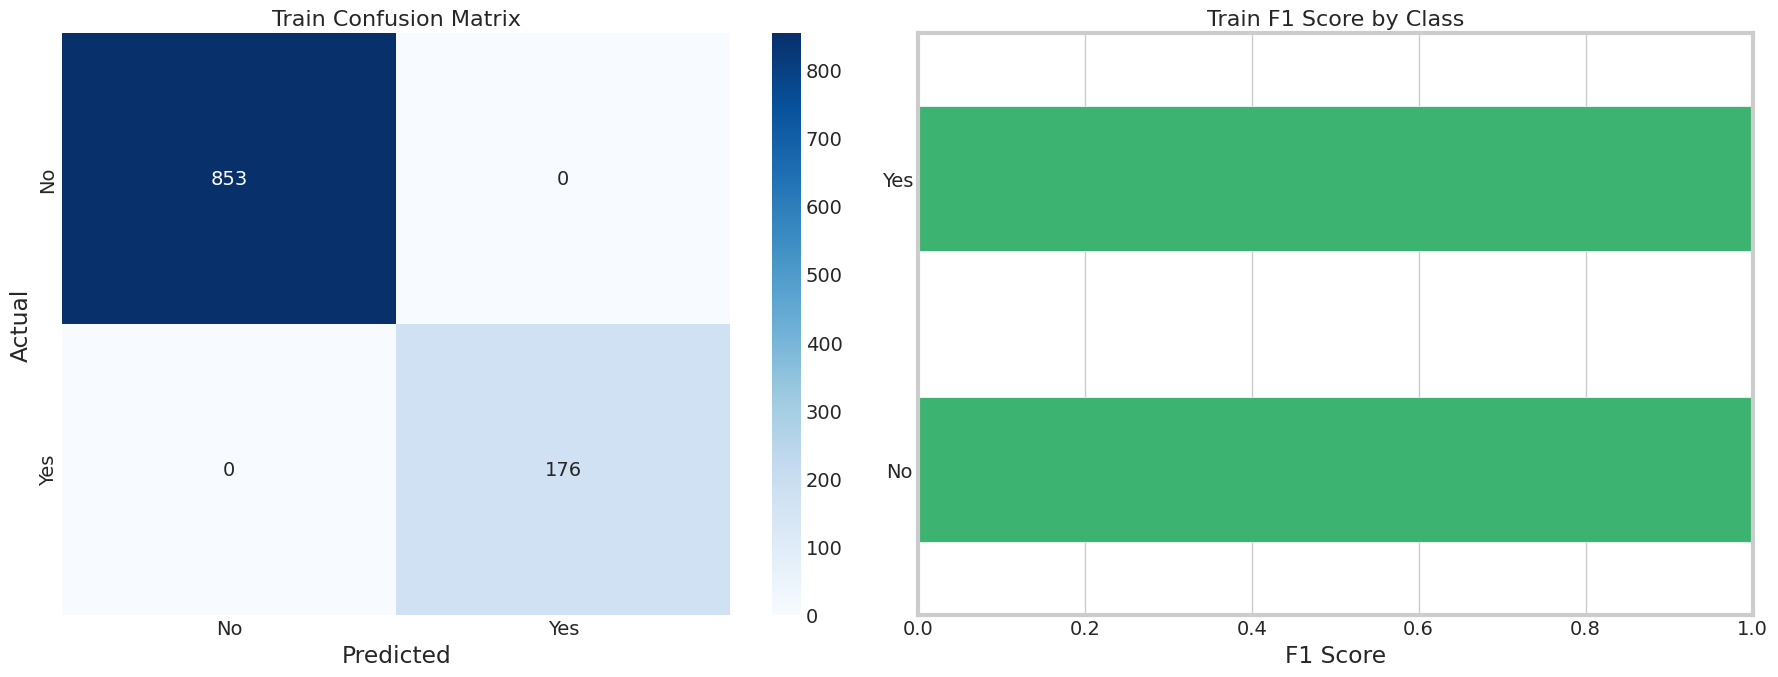


Test Result:
————————————————————————————————————————
Accuracy: 77.78%


,precision,recall,f1-score,support
No,0.89,0.85,0.87,380.00
Yes,0.26,0.33,0.29,61.00
accuracy,0.78,0.78,0.78,0.78
macro avg,0.57,0.59,0.58,441.00
weighted avg,0.80,0.78,0.79,441.00


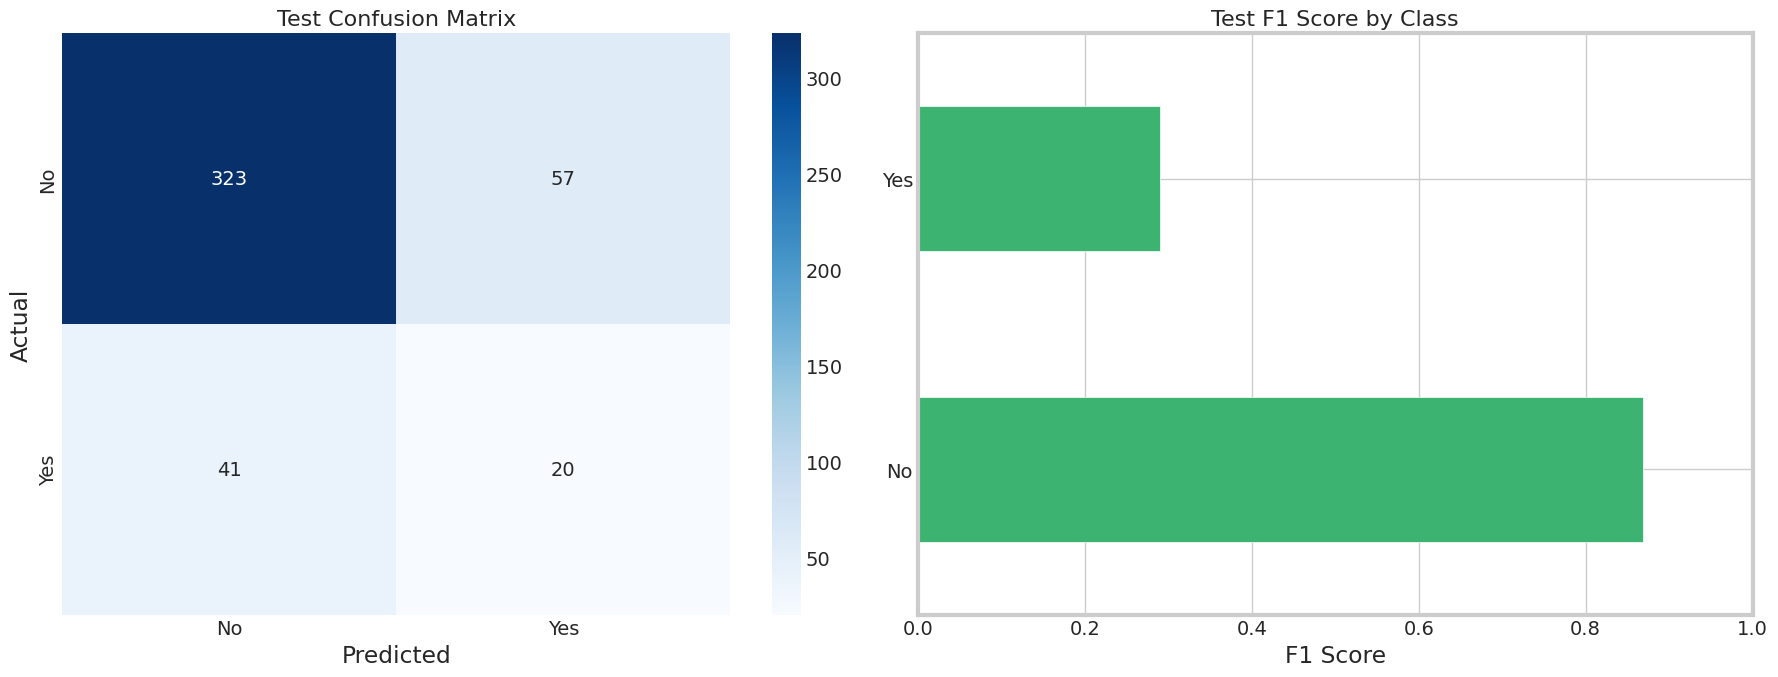

In [168]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

## Decision Tree Classifier Hyperparameter Tuning

In [169]:
params = {
    "criterion":("gini", "entropy"),
    "splitter":("best", "random"),
    "max_depth":(list(range(1, 20))),
    "min_samples_split":[2, 3, 4],
    "min_samples_leaf":list(range(1, 20)),
}

tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(
    tree_clf,
    params,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
    cv=5
)

tree_cv.fit(X_train, y_train)
best_params = tree_cv.best_params_
print("Best paramters:")
for param in best_params:
    print(f"- {param}")

Fitting 5 folds for each of 4332 candidates, totalling 21660 fits


Best paramters:
- criterion
- max_depth
- min_samples_leaf
- min_samples_split
- splitter



Train Result:
————————————————————————————————————————
Accuracy: 86.78%


,precision,recall,f1-score,support
No,0.89,0.96,0.92,853.00
Yes,0.69,0.41,0.51,176.00
accuracy,0.87,0.87,0.87,0.87
macro avg,0.79,0.69,0.72,1029.00
weighted avg,0.85,0.87,0.85,1029.00


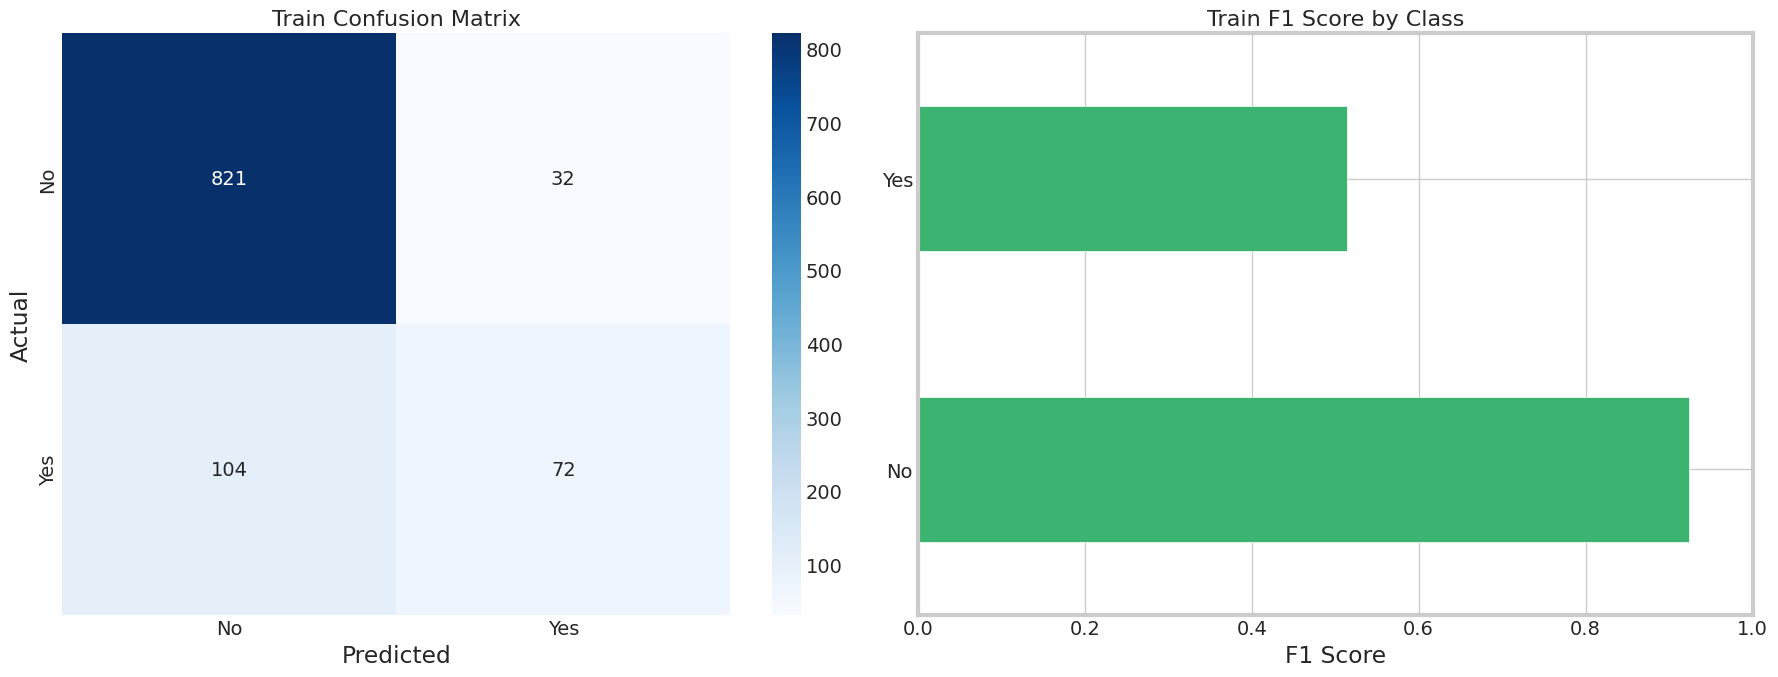


Test Result:
————————————————————————————————————————
Accuracy: 87.30%


,precision,recall,f1-score,support
No,0.89,0.97,0.93,380.00
Yes,0.59,0.26,0.36,61.00
accuracy,0.87,0.87,0.87,0.87
macro avg,0.74,0.62,0.65,441.00
weighted avg,0.85,0.87,0.85,441.00


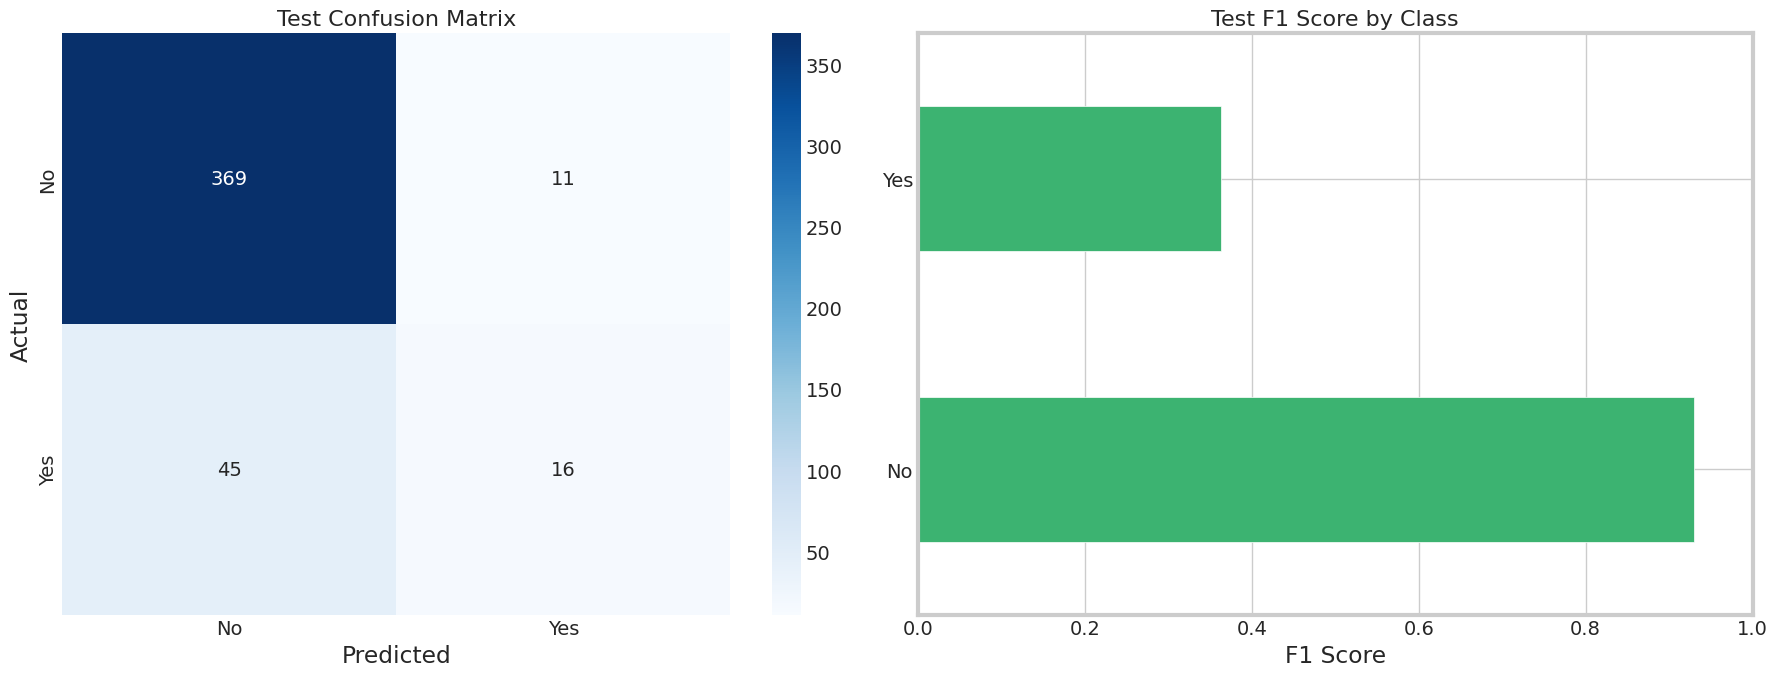

In [170]:
tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(X_train, y_train)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

## Feature Importance

In [171]:
importances = tree_clf.feature_importances_
feature_names = X_train.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances.head(5))

              Feature  Importance
18           OverTime    0.219198
15      MonthlyIncome    0.201153
23  TotalWorkingYears    0.122524
14      MaritalStatus    0.071408
4    DistanceFromHome    0.062421


## Visualization of the Tree

In [172]:
features = list(df.columns)
features.remove("Attrition")

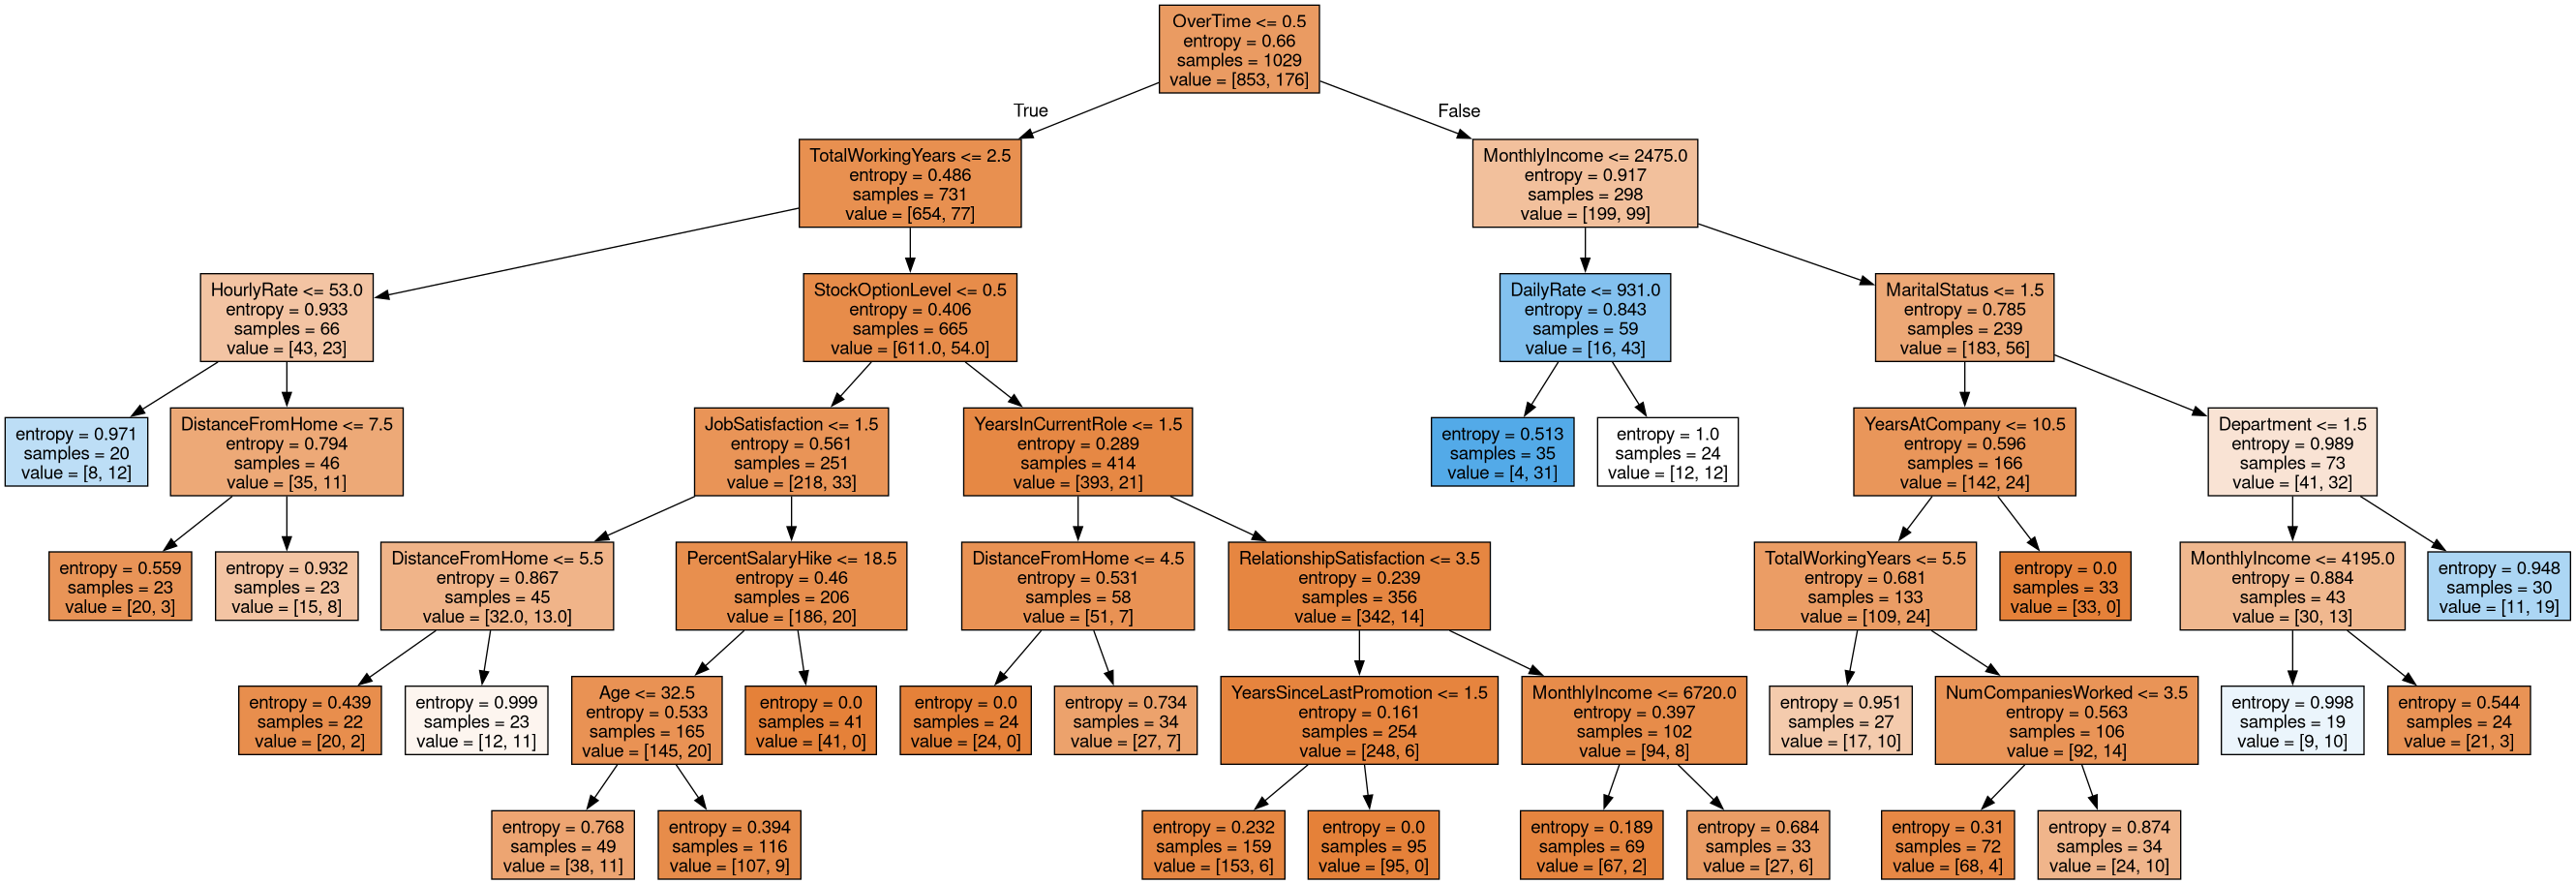

In [173]:
dot_data = StringIO()
export_graphviz(tree_clf, out_file=dot_data, feature_names=features, filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

## References

[1] F. Pedregosa, G. Varoquaux, A. Gramfort, V. Michel, B. Thirion, O. Grisel, M. Blondel, P. Prettenhofer, R. Weiss, V. Dubourg, J. Vanderplas, A. Passos, D. Cournapeau, M. Brucher, M. Perrot, and E. Duchesnay, "Scikit-learn: Machine Learning in Python," J. Mach. Learn. Res., vol. 12, pp. 2825-2830, 2011.